<a href="https://colab.research.google.com/github/Charles-Li26/SEP788-Adverse-Condition-Object-Detection/blob/main/Image_Pre_processing_(Lightness%2C_Noise_and_Raindrop).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Lightness Improvement

1. Upload Image

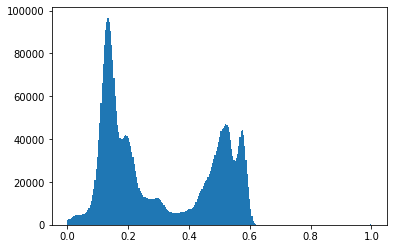

In [ ]:
import matplotlib.pyplot as plt
rain1 = plt.imread(r'/content/cloud/25.png')
ax = plt.hist(rain1.ravel(), bins=256)
plt.show() # the histogram shows the iamge distribution of grey levels in the image

2. Grey Level Normalization

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


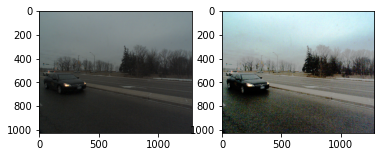

<Figure size 7200x7200 with 0 Axes>

In [ ]:
#normalize the grey level so that the lightness can improve
import matplotlib.pyplot as plt 
from skimage import exposure

moon1 = plt.imread(r'/content/cloud/25.png')
moon2 = exposure.equalize_hist(rain1)
plt.subplot(121), plt.imshow(moon1, 'gray')
plt.subplot(122), plt.imshow(moon2, 'gray')
plt.figure(figsize=(100,100))
img_path = r'C:\Users\Calvin Xu\Desktop\Snow check\雪2\00.jpg'
plt.imsave(img_path, moon2)
plt.show()

# Noise Reduction

1. Using CV.morphologyEX

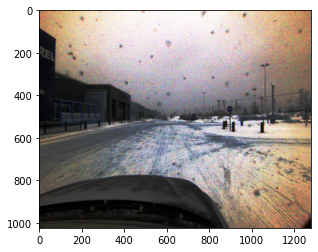

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img=cv.imread("1.jpg")
kernel=np.ones((1,1),np.uint8)
opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
plt.imshow(closing)

2. cv.dilate

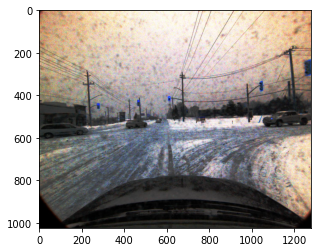

In [ ]:
kernel=np.ones((1,1),np.uint8)

dilation = cv.dilate(img,kernel,iterations = 100)
plt.imshow(dilation)

# RainDrop Removal Neural Network

Referenced: https://blog.csdn.net/Wenyuanbo/article/details/116541682

1. Upload Rainning Image from GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

2. Upload Training Dataset and Pre-processing

In [1]:
import os
import torchvision
from torch.utils.data import  Dataset
from PIL import Image

#Import the dataset
class MyTrainDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path #It is the rainning image file
        self.input_files = os.listdir(input_path) #upload all the image at that file

        self.label_path = label_path #the clean image file
        self.label_files = os.listdir(label_path)

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop([64, 64]),#cute the image to 64 X 64 as pacth
            torchvision.transforms.ToTensor(), #normalize the data into 0 to 1
            ])

    def __len__(self):
        return len(self.input_files) #return the length
    def __getitem__(self, index):
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        # Use PIL.Image to read in image data and convert the channel structure
        input_image = Image.open(input_image_path).convert('RGB') 

        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')

        # Perform a fixed transformation on the imported picture
        input = self.transforms(input_image)
        label = self.transforms(label_image)
        # Return image data suitable for training in the network
        return  (input, label)

2. Neural Network

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.res_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.res_conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.res_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.res_conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.res_conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.conv = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1),
        )
    def forward(self, input):
        
        x = input
        for i in range(6):# 迭代次数，不改变网络参数量
            
            x = torch.cat((input, x), 1)
            x = self.conv0(x)
            x = F.relu(self.res_conv1(x) + x)
            x = F.relu(self.res_conv2(x) + x)
            x = F.relu(self.res_conv3(x) + x)
            x = F.relu(self.res_conv4(x) + x)
            x = F.relu(self.res_conv5(x) + x)
            x = self.conv(x)
            x = x + input
            
        return x

3. Test Dataset Pre-processing

In [3]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class MyTestDataset(Dataset):
    def __init__(self, input_path): 
        super(MyTestDataset, self).__init__()
        self.input_path = input_path #It is the rainning image file
        self.input_files = os.listdir(self.input_path)
        self.transforms = transforms.Compose([
            transforms.ToTensor(),#normalize the data into 0 to 1
            ])

    def __len__(self):
        return len(self.input_files) #return the length

    def __getitem__(self, index):
        # Use PIL.Image to read in image data and convert the channel structure
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        input = self.transforms(input_image)
        # Return image data suitable for testing in the network
        return input

4. Training Process

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

# 训练图像的路径
input_path = '/content/drive/MyDrive/rain_test/training_input'
label_path = '/content/drive/MyDrive/rain_test/training-label'
net = Net().cuda()

learning_rate = 1e-3
batch_size = 100 # 分批训练数据，每批数据量
epoch = 100 # 训练次数
Loss_list = [] # 简单的显示损失曲线列表，反注释后训练完显示曲线

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_f = nn.MSELoss()
net.train()

if os.path.exists('./model.pth'):# 判断模型有没有提前训练过
    print("继续训练！")
    net.load_state_dict(torch.load('./model.pth'))# 加载训练过的模型
else:
    print("从头训练！")

for i in range(epoch):
    dataset_train = MyTrainDataset(input_path, label_path)
    trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True)

    for j, (x, y) in enumerate(trainloader):# 加载训练数据
        input = Variable(x).cuda()
        label = Variable(y).cuda()

        net.zero_grad()
        optimizer.zero_grad()

        output = net(input)
        loss = loss_f(output, label)

        optimizer.zero_grad()
        loss.backward() # 反向传播
        optimizer.step()

        print("已完成第{}次训练的{:.3f}%，目前损失值为{:.6f}。".format(i+1, ((j+1)/35)*100, loss))

        # Loss_list.append(loss)

        if j%9 == 0:
            torch.save(net.state_dict(), 'model.pth') # 保存训练模型

5. Test the result

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# 测试图像的路径
input_path = '/content/test'

net = Net().cuda()
net.load_state_dict(torch.load('./model.pth')) # 加载训练好的模型参数
net.eval()

cnt = 0

dataloader = DataLoader(MyTestDataset(input_path))
for input in dataloader:
    cnt += 1
    input = input.cuda()

    print('finished:{:.2f}%'.format(cnt*100/1400))

    with torch.no_grad():
        output_image = net(input) # 输出的是张量
        save_image(output_image, '/content'+str(cnt).zfill(4)+'.jpg') # 直接保存张量图片，自动转换